In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
reload(dpp)

<module 'data_prep_pyn' from '/mnt/home/szheng/projects/util_code/data_prep_pyn.py'>

In [3]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][2] #0

# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat')
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']
cell_metrics = mat_to_return['cell_metrics']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=True,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
# spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,bin_size=2.2,nbins=None)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']


load *SessionPulses.Events.mat failed


/mnt/home/szheng/projects/util_code/data_prep_pyn.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[val.index,info_key] = info_val_l_new[int(k[0])][int(k[1])]


/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/spk_beh_df.p saved!


In [135]:
prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
# spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,bin_size=2.2,nbins=None)
cell_cols_d = prep_res['cell_cols_d']


In [ ]:
da

In [205]:
pd.concat(pf_res['avg']['all_fields'],axis=0)

start end com peak   fr_peak   fr_mean
          field_index                                       
0 0.0 45  0              33  44  38   39  9.764945  6.577983
          1              78  88  83   83  6.534244  5.289119
      46  0              38  48  43   44  9.276232  6.997467
          1              52  57  54   55  5.485646  5.119123
      50  0               9  21  15   13  3.841499  3.381766
...                     ...  ..  ..  ...       ...       ...
1 1.0 339 1              52  57  54   54   1.84418  1.678458
          2              78  86  81   82  2.786722  2.281186
      340 0              20  27  23   24  5.393056  4.446701
          1              50  61  55   55  6.694309  5.094577
      341 0              19  30  24   23  4.947537  3.706425

[1184 rows x 6 columns]

In [136]:
reload(pa)
cell_cols = cell_cols_d['pyr']
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,trialtype_key='trial_type',speed_key='v',speed_thresh=1.,order=['smooth','divide'])
fr_map_trial_d = {k:val[0] for k,val in fr_map_dict.items()}
fr_map_trial_df_d=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_dict.keys()},axis=0)


cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe


In [137]:
pf_res =pf.field_detection_both_avg_trial_wrapper(data_dir_full, dosave=True,force_reload=False,nbins = 100, 
                                        save_fn = 'place_field_avg_and_trial_vthresh.p', 
                                        shuffle_fn='fr_map_null_trialtype_vthresh.p',
                                        smth_in_bin=2.5, speed_thresh=1.,speed_key='v',load_only=True
                                        )

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220119/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


In [138]:
switch_res = saos.switch_analysis_one_session(data_dir_full,place_field_res=None,force_reload=False,nrepeats=1000,
                                              save_fn=saos.SAVE_FN(saos.FR_KEY),load_only=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220119/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---


In [140]:
all_fields_all_trialtype=pd.concat(pf_res['avg']['all_fields'],axis=0)

fr_map_concat,index_within_to_trial_index_df = pa.concat_fr_map_trial_df_d(fr_map_trial_df_d,spk_beh_df)

IndexError: index 29 is out of bounds for axis 1 with size 29

<AxesSubplot:xlabel='Time (s)'>

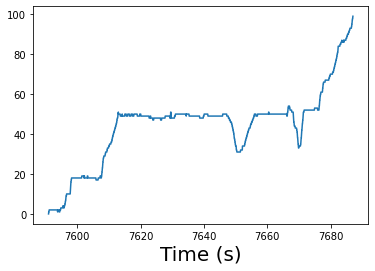

In [160]:
%matplotlib inline
spk_beh_df.query('(task_index==0)&(trial==11)')['lin_binned'].plot()

In [147]:
spk_beh_df.query('task_index==0').groupby('trial').apply(lambda x:x.notna().any())

,1,2,3,4,5,6,7,8,9,10,...,trial,task_index,task,speed,visitedArm,direction,correct,v,trial_type,lin_binned
trial,,,,,,,,,,,,,,,,,,,,,
0.0,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,False,True,True,True
1.0,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2.0,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3.0,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4.0,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
5.0,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
6.0,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,False,True,True
7.0,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
8.0,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [151]:
dpp.index_within_to_trial_index(spk_beh_df).loc[0]

tt_ind  index
0.0     0         1
        1         2
        2         4
        3         5
        4         7
        5         9
        6        10
        7        12
        8        15
        9        16
        10       18
        11       20
        12       22
        13       23
        14       25
        15       27
        16       28
        17       29
        18       30
1.0     0         0
        1         3
        3         8
        5        13
        6        14
        7        17
        8        19
        9        21
        10       24
        11       26
Name: trial_ind, dtype: int64

In [96]:
fr_map_concat

0          1          2          3          4          5   \
0 1.0   0   77.068211  44.552611  37.188450  38.213012  27.240400  20.396137   
        1   77.631444  44.195689  36.665435  38.591527  27.284503  21.159197   
        2   78.143310  43.710166  36.186047  39.022873  27.416703  21.976254   
        3   78.405299  43.212758  35.914739  39.466580  27.680528  22.738712   
        4   78.298149  42.793816  35.941300  39.953497  28.127186  23.484283   
...               ...        ...        ...        ...        ...        ...   
  363.0 95   0.002051   0.008520   0.000000   0.004029   0.000000   0.000000   
        96   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
        97   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
        98   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
        99   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   

                   6          7          8          9   ...         22  \
0 1.0   0   31.548764  27.428040  30.637380  56.328990  ...  25.878505   
        1   31.699033  27.007920  31.104506  53.758506  ...  25.499666   
        2   31.875679  26.690207  31.597239  50.780244  ...  24.998685   
        3   32.068212  26.513105  31.974037  47.967199  ...  24.608726   
        4   32.295652  26.447877  32.268328  45.336213  ...  24.420688   
...               ...        ...        ...        ...  ...        ...   
  363.0 95   0.000000   0.000000   0.000000   0.000000  ...   0.000000   
        96   0.000000   0.000000   0.000000   0.000000  ...   0.000000   
        97   0.000000   0.000000   0.000000   0.000000  ...   0.000000   
        98   0.000000   0.000000   0.000000   0.000000  ...   0.000000   
        99   0.000000   0.000000   0.000000   0.000000  ...   0.000000   

                   23         24         25         26         27         28  \
0 1.0   0   21.023873  24.460278  15.991967  17.276107  26.302982  33.763672   
        1   20.907996  25.136769  16.468722  17.023342  26.515391  33.674212   
        2   20.770911  26.147044  17.029005  16.778329  26.777856  33.572301   
        3   20.689755  27.190078  17.576933  16.615423  27.052083  33.553769   
        4   20.774025  28.057693  18.127120  16.585618  27.351428  33.726077   
...               ...        ...        ...        ...        ...        ...   
  363.0 95   0.225085   0.000000   0.000000   7.930298   1.621737   1.315003   
        96   0.182467   0.000000   0.000000   7.964136   1.603199   1.194479   
        97   0.145314   0.000000   0.000000   7.867198   1.566205   1.057908   
        98   0.113152   0.000000   0.000000   7.662227   1.519845   0.906526   
        99   0.070830   0.000000   0.000000   7.295570   1.428218   0.761040   

                   29         30         31  
0 1.0   0   14.344931  23.425238  28.811582  
        1   14.803236  22.629312  28.206518  
        2   15.447862  21.796810  27.563890  
        3   16.177965  21.088717  27.009085  
        4   16.984138  20.485497  26.518100  
...               ...        ...        ...  
  363.0 95   5.761353   0.000000  12.347807  
        96   5.461412   0.000000  12.292947  
        97   5.132562   0.000000  11.881548  
        98   4.782290   0.000000  11.236639  
        99   4.337809   0.000000  10.387767  

[31800 rows x 32 columns]

In [75]:
index_within_to_trial_index_df.loc[1]

tt_ind  index
0.0     0         1
        1         3
        2         5
        3         7
        4         9
                 ..
1.0     30       60
        31       62
        32       64
        33       66
        34       67
Name: trial_ind, Length: 68, dtype: int64

In [40]:
switch_res['avg']['fig']

{(0, 0): {'raw': {'switch_magnitude': <Figure size 1200x600 with 8 Axes>},
  0.3: {'switch_magnitude': <Figure size 1200x600 with 8 Axes>}},
 (0, 1): {'raw': {'switch_magnitude': <Figure size 1200x600 with 8 Axes>},
  0.3: {'switch_magnitude': <Figure size 1200x600 with 8 Axes>}}}

In [129]:
db.query('owner=="roman"').sort_values('ntrials',ascending=False)

data_dir_full  \
animal_name                                                        
e13_26m1    1  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
            0  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
e15_13f1    2  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
e16_3m2     3  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m...   
e15_13f1    3  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
...                                                          ...   
e16_2m1     3  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m...   
e16_3m1     0  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m...   
e15_10m1    2  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_10...   
e14_2m2     0  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   
e16_2m1     0  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m...   

                     sess_name animal_name.1        date  \
animal_name                                                
e13_26m1    1  e13_26m1_211019      e13_26m1  2021-10-19   
            0  e13_26m1_210913      e13_26m1  2021-09-13   
e15_13f1    2  e15_13f1_220119      e15_13f1  2022-01-19   
e16_3m2     3   e16_3m2_211213       e16_3m2  2021-12-13   
e15_13f1    3  e15_13f1_220120      e15_13f1  2022-01-20   
...                        ...           ...         ...   
e16_2m1     3   e16_2m1_201129       e16_2m1  2020-11-29   
e16_3m1     0   e16_3m1_210111       e16_3m1  2021-01-11   
e15_10m1    2  e15_10m1_200723      e15_10m1  2020-07-23   
e14_2m2     0   e14_2m2_201013       e14_2m2  2020-10-13   
e16_2m1     0   e16_2m1_201116       e16_2m1  2020-11-16   

                                    behavior  performance  ntrials  \
animal_name                                                          
e13_26m1    1  ['alternation' 'alternation']     0.730769       78   
            0                    alternation     0.956522       69   
e15_13f1    2  ['alternation' 'alternation']     0.721311       61   
e16_3m2     3  ['alternation' 'alternation']     0.703704       54   
e15_13f1    3   ['alternation' 'linearMaze']     0.800000       45   
...                                      ...          ...      ...   
e16_2m1     3                    alternation     0.823529       17   
e16_3m1     0                    alternation     0.882353       17   
e15_10m1    2                    alternation     0.866667       15   
e14_2m2     0                    alternation     0.857143       14   
e16_2m1     0                    alternation     0.636364       11   

               ngoodtrials  n_neurons  n_pyr_putative  owner   data_root  
animal_name                                                               
e13_26m1    1           78        271             228  roman  roman_data  
            0           69        482             422  roman  roman_data  
e15_13f1    2           61        343             288  roman  roman_data  
e16_3m2     3           54        207             163  roman  roman_data  
e15_13f1    3           45        303             248  roman  roman_data  
...                    ...        ...             ...    ...         ...  
e16_2m1     3           17         69              57  roman  roman_data  
e16_3m1     0           17        203             162  roman  roman_data  
e15_10m1    2           15         98              71  roman  roman_data  
e14_2m2     0           14        200             159  roman  roman_data  
e16_2m1     0           11         50              37  roman  roman_data  

[67 rows x 12 columns]

In [194]:
sess_l = ["e15_13f1_220117","e15_13f1_220118","e13_26m1_210913","e13_26m1_211019","e16_3m2_211213"]

sess = sess_l[3]
# sess = 'e15_13f1_220119'
data_dir_full = db.query('sess_name==@sess')['data_dir_full'][0]

<IPython.core.display.Javascript object>


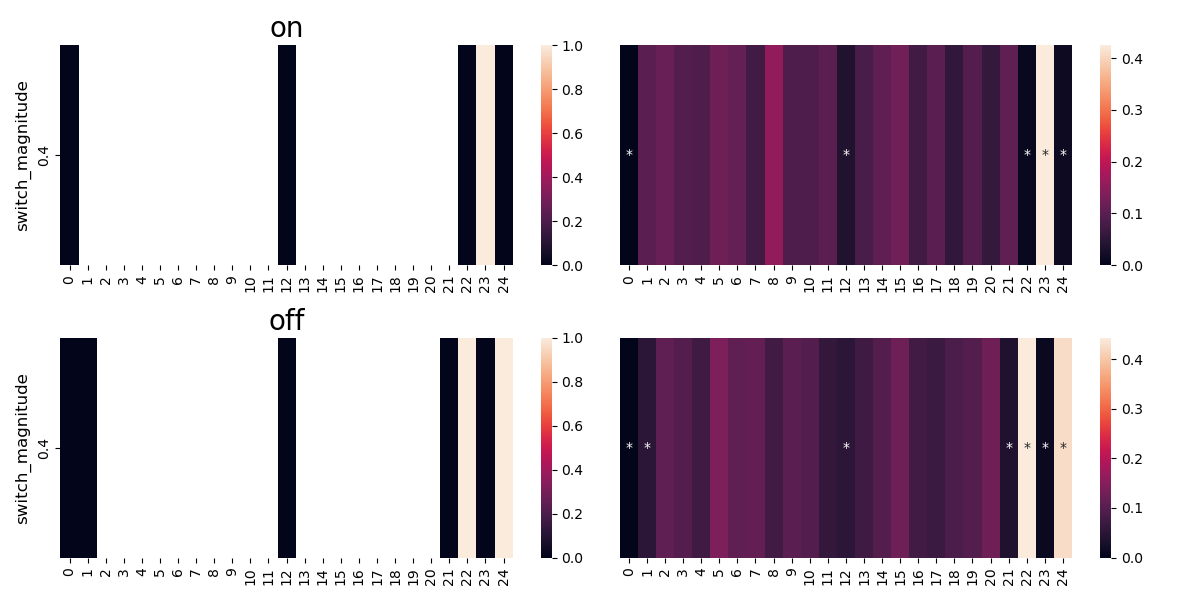

<IPython.core.display.Javascript object>


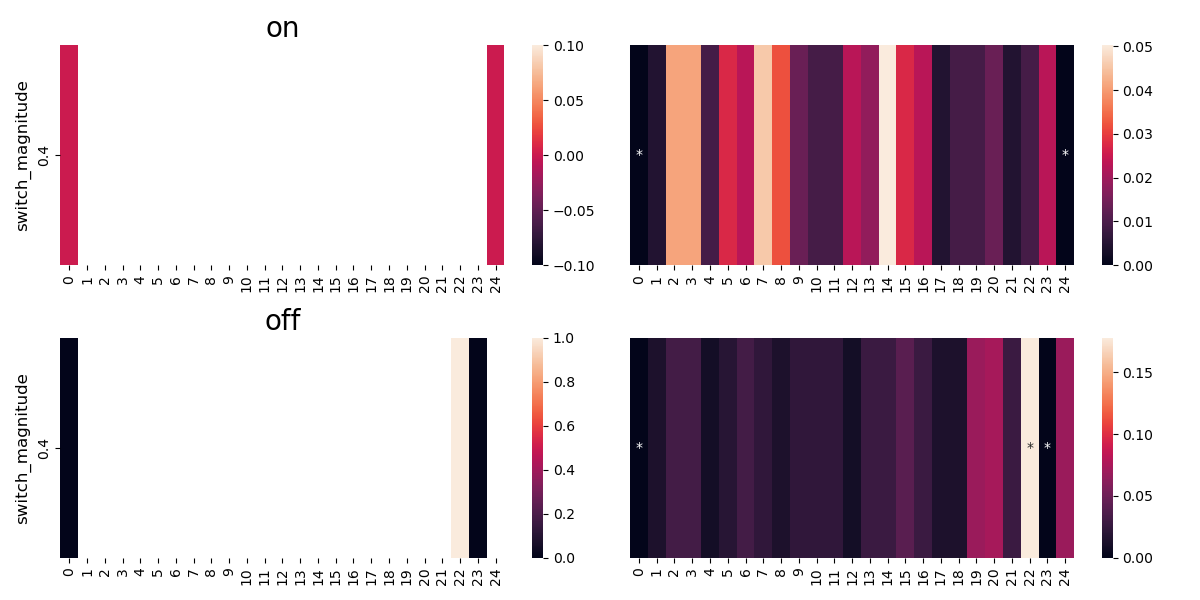

<IPython.core.display.Javascript object>


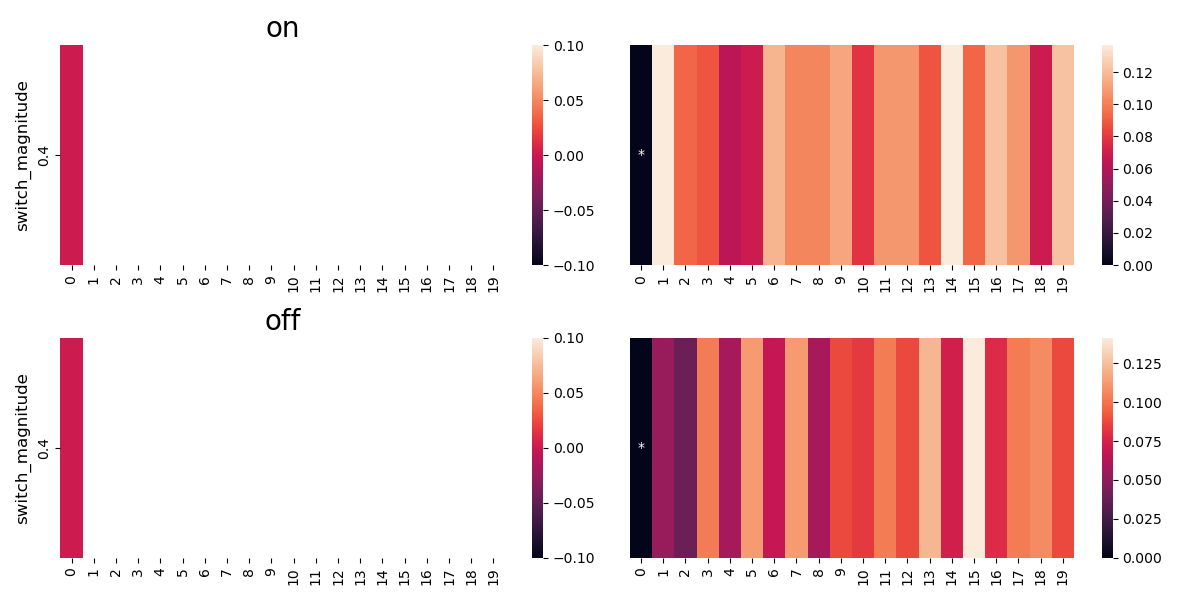

<IPython.core.display.Javascript object>


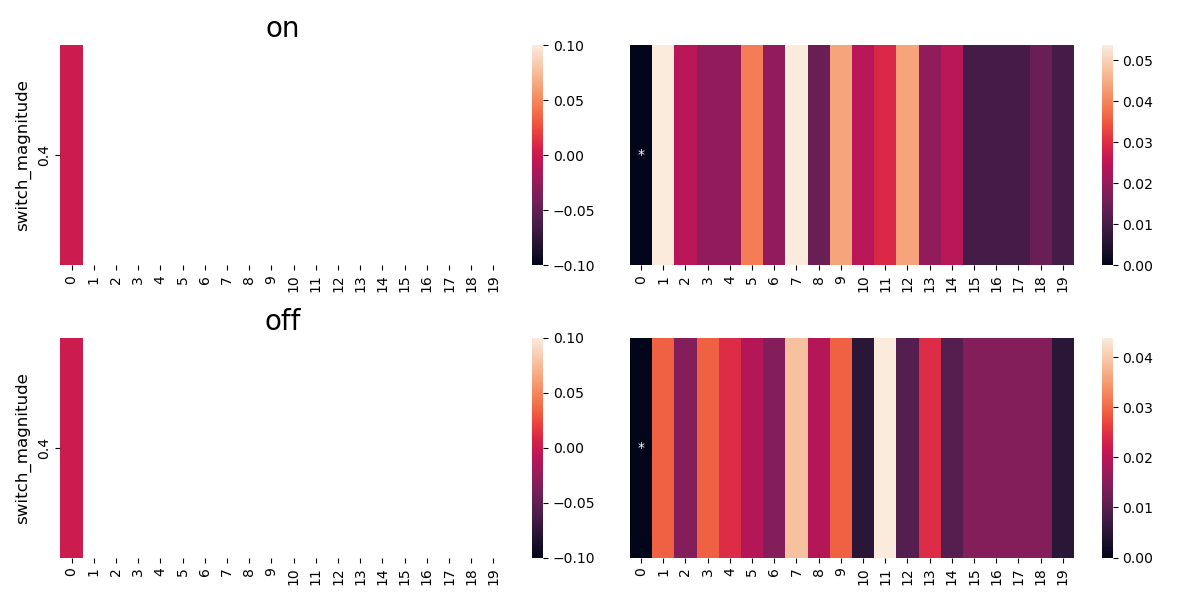

<IPython.core.display.Javascript object>


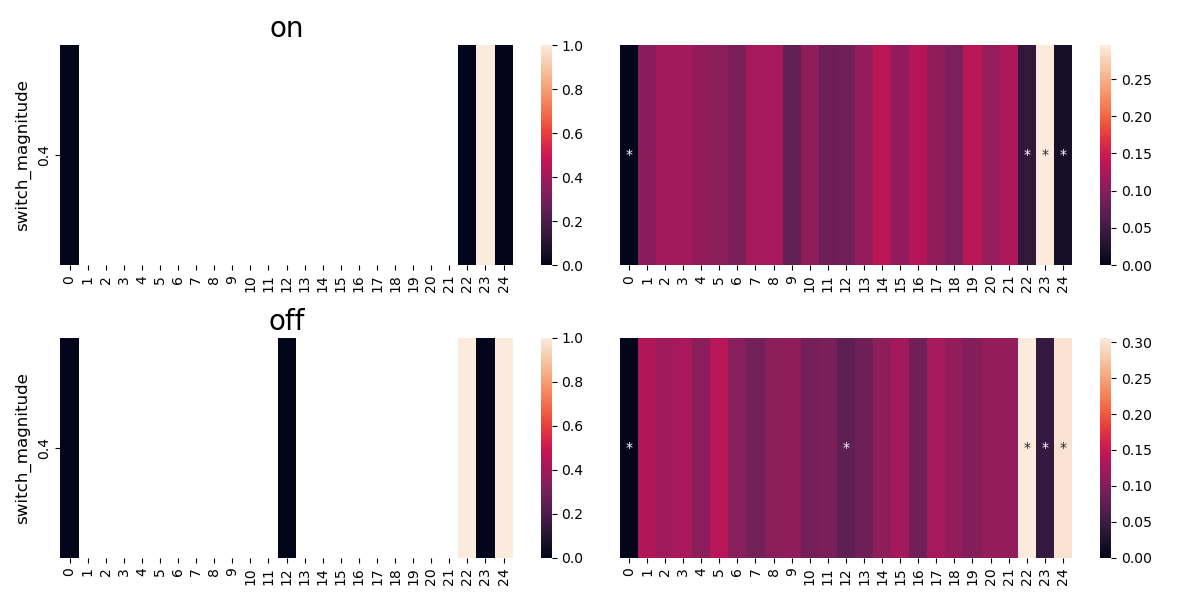

<IPython.core.display.Javascript object>


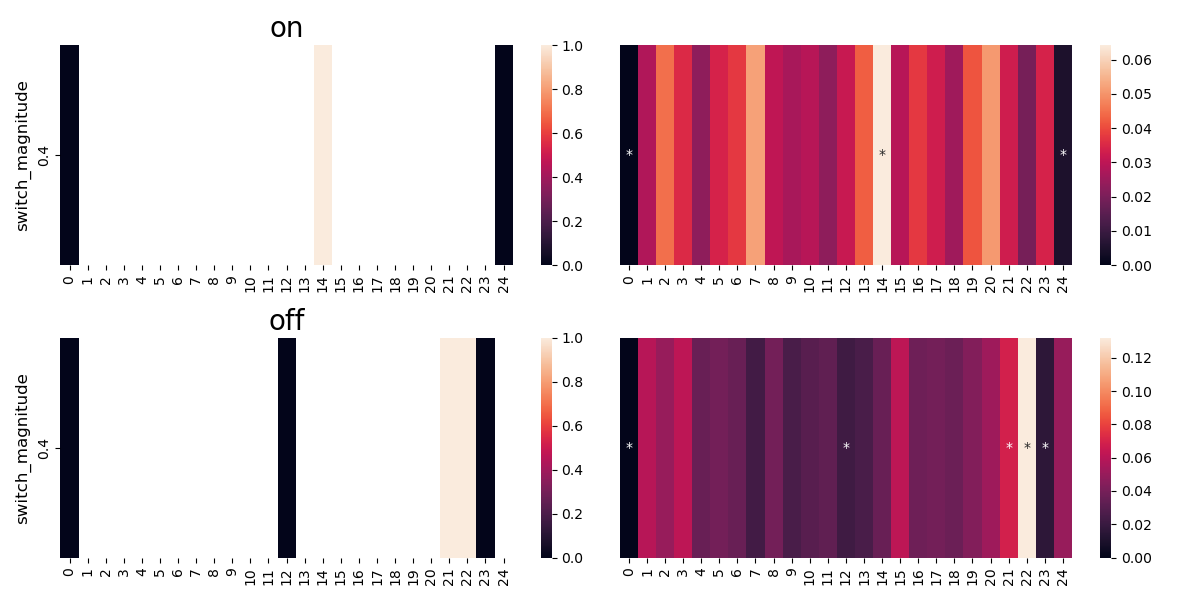

<IPython.core.display.Javascript object>


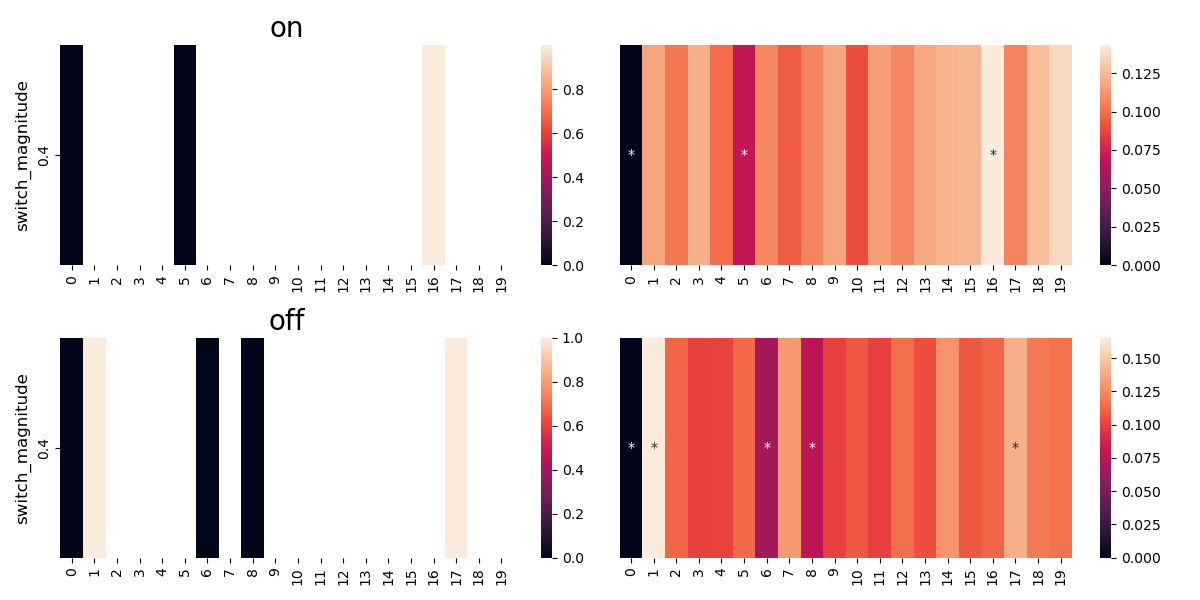

<IPython.core.display.Javascript object>


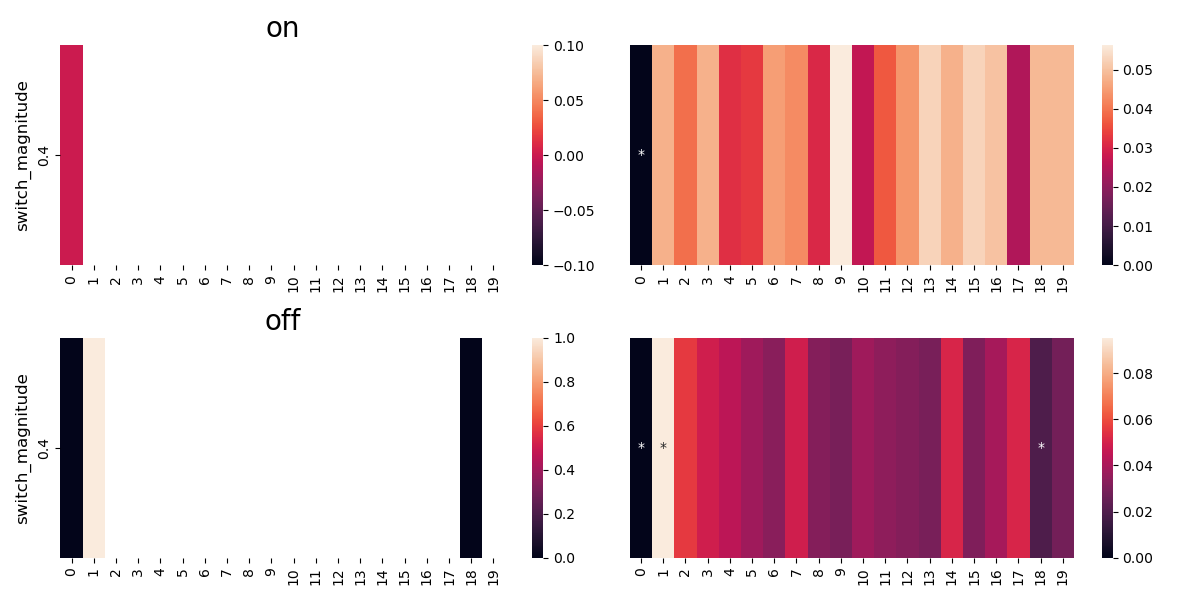

<IPython.core.display.Javascript object>


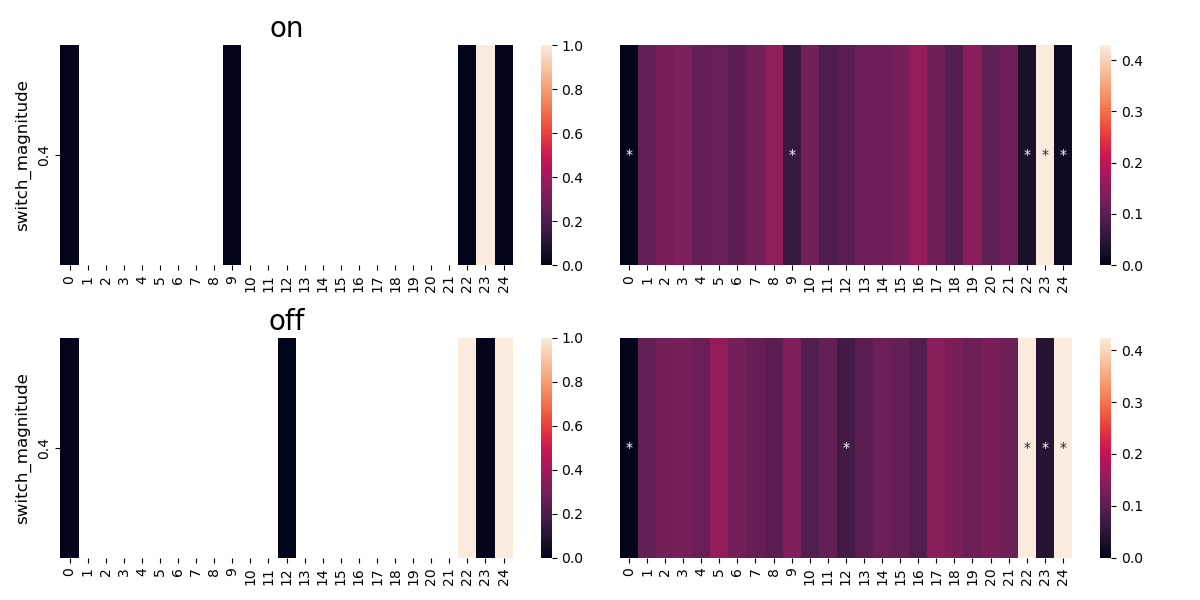

<IPython.core.display.Javascript object>


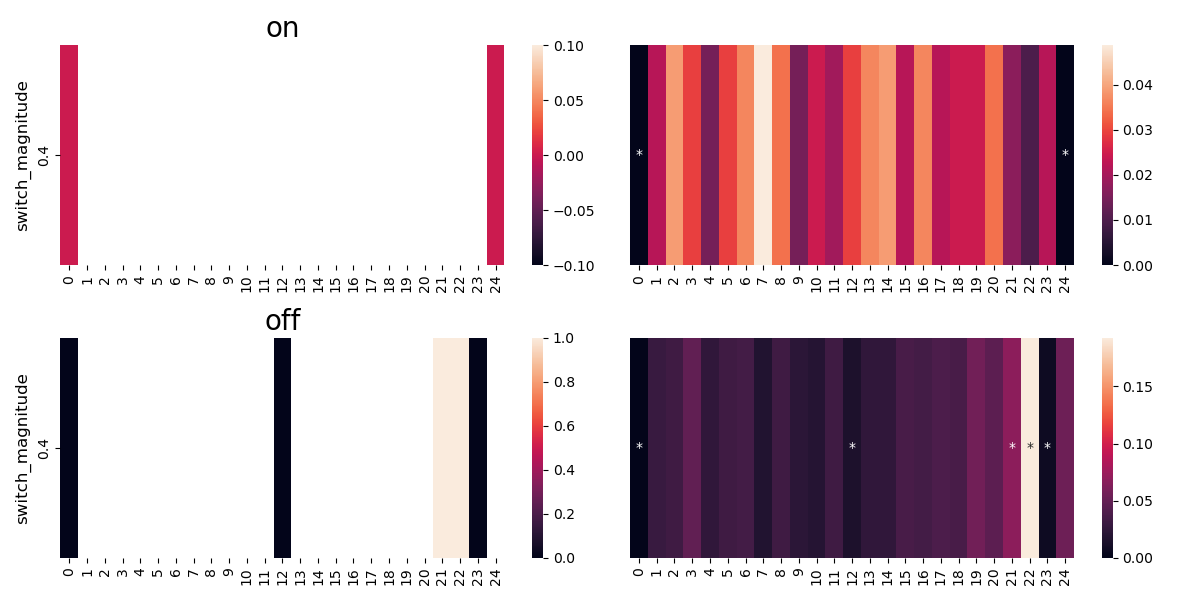

<IPython.core.display.Javascript object>


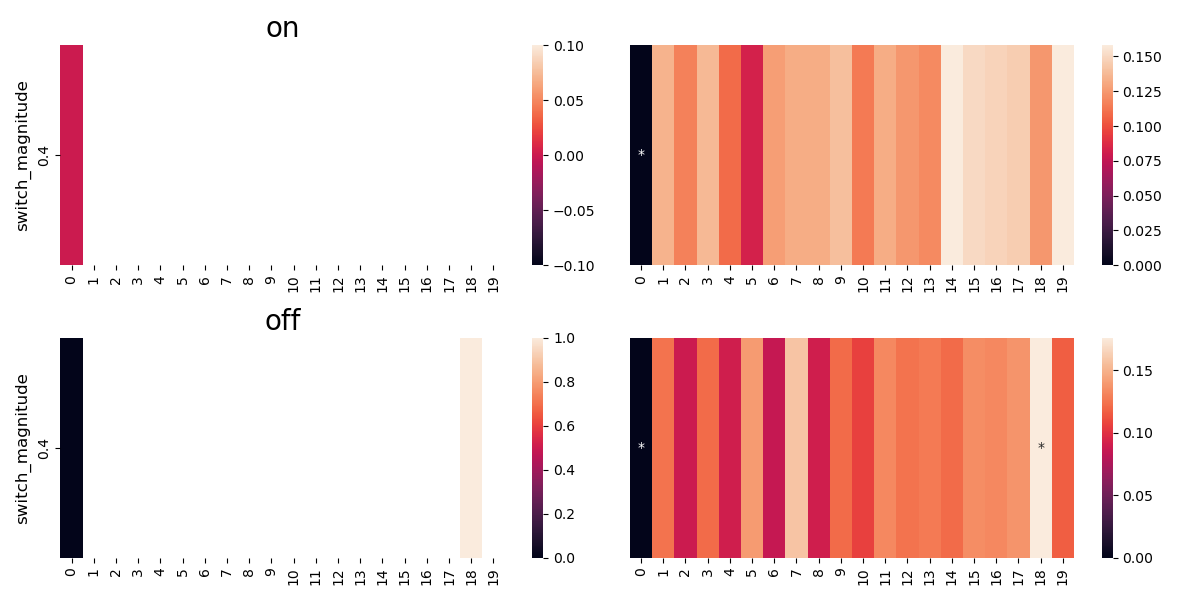

<IPython.core.display.Javascript object>


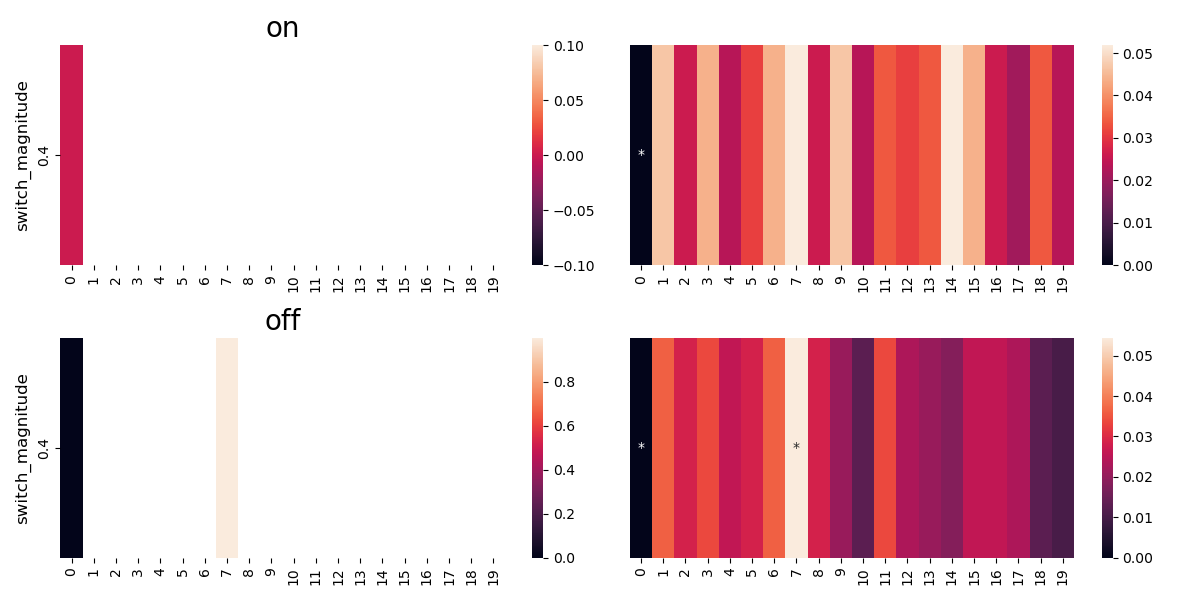

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211019/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---


In [195]:
switch_res = saos.switch_analysis_one_session(data_dir_full,place_field_res=None,force_reload=False,nrepeats=1000,
                                              save_fn=saos.SAVE_FN(saos.FR_KEY),load_only=True)

<IPython.core.display.Javascript object>


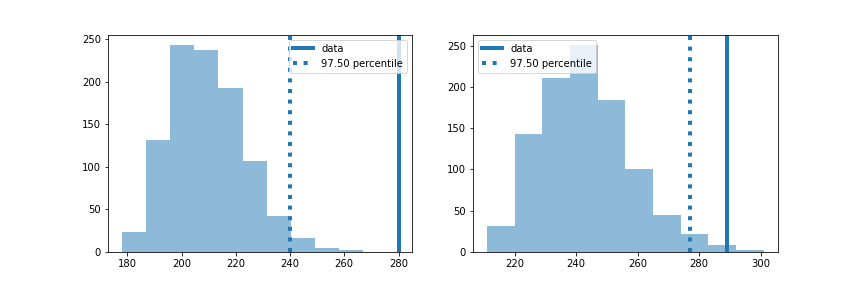

In [197]:
task_ind = 0
query=(task_ind,slice(None),0.3,'switch_magnitude',0.4)
changes_df_both = switch_res['avg']['changes_df'].loc[query]
fig,axs=plt.subplots(1,2,figsize=(12,4))
for ii,i in enumerate([0,1]):
    changes_one = changes_df_both.loc[i].dropna(axis=1)
    res,share_shuffle = cpa.shuffle_test_pair_share_onoff(changes_one,nrepeats=1000,alpha=0.025)
    fig,ax=ph.plot_shuffle_data_dist_with_thresh(share_shuffle['on'],res.loc['count','on'],alpha=0.025,fig=fig,ax=axs[ii],lw=4)

In [201]:
test_res.keys()

dict_keys(['test_res_df', 'count_shuffle', 'all_sw_times_v_combined', 'all_fields_times_v', 'changes_df_combined', 'changes_df_combined_d', 'pf_loc_combined', 'trial_pos_info', 'pos_to_time_func_per_trial', 'pf_all_field_combined'])

In [168]:
%%time
reload(pca)
reload(dpp)
reload(cpacas)

# edges = np.concatenate([np.linspace(0,1,10),np.arange(1,400,10)])
edges = np.concatenate([np.linspace(0,0.9,9),np.arange(1,400,10)])
test_res = cpacas.sweep_test_coswitch_wrapper(data_dir_full,
                                pf_res_save_fn='place_field_avg_and_trial_vthresh.p',
                                pf_shuffle_fn = 'fr_map_null_trialtype_vthresh.p',
                                speed_key='v',
                                bin_size=2.2,
                                switch_res_query=(slice(None),0.3,'switch_magnitude',0.4),
                                nrepeats_sw = 100,
                                edges = edges,
                                force_reload=False,
                                dosave=True,
                                task_ind = 0,
                                prep_force_reload=False,
                                )
test_res_df=test_res['test_res_df']

cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220119/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220119/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
saved at /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220119/py_data/switch_analysis/switch_res_window.p
CPU times: user 23.9 s, sys: 4.76 s, total: 28.7 s
Wall time: 33.4 s


In [98]:
%%time
import tqdm
reload(pca)
reload(dpp)
reload(cpacas)
subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
edges = np.concatenate([np.linspace(0,0.9,9),np.arange(1,400,10)])

success_sess = []
fail_sess = []

for i in tqdm.tqdm(range(subdb.shape[0])):
    row = subdb.iloc[i]
    sess = row['sess_name'] 
    ddf = row['data_dir_full']
    try:
        test_res = cpacas.sweep_test_coswitch_wrapper(ddf,
                                    pf_res_save_fn='place_field_avg_and_trial_vthresh.p',
                                    pf_shuffle_fn = 'fr_map_null_trialtype_vthresh.p',
                                    speed_key='v',
                                    bin_size=2.2,
                                    switch_res_query=(slice(None),0.3,'switch_magnitude',0.4),
                                    nrepeats_sw = 1000,
                                    edges = edges,
                                    force_reload=True,
                                    dosave=True,
                                    task_ind = 0,
                                    prep_force_reload=True,
                                    )
        success_sess.append(sess)
    except Exception as e:
        fail_sess.append((sess,e))
        print(f'{sess} failed, {e}')








  0%|          | 0/67 [00:00<?, ?it/s]/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


  1%|▏         | 1/67 [07:00<7:42:16, 420.25s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/switch_res_window.p


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


  3%|▎         | 2/67 [10:13<5:10:39, 286.75s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/switch_res_window.p


/mnt/home/szheng/projects/util_code/data_prep_pyn.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[val.index,info_key] = info_val_l_new[int(k[0])][int(k[1])]


/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


  4%|▍         | 3/67 [12:56<4:05:25, 230.08s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/switch_analysis/switch_res_window.p
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220119/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220119/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220119/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---


  6%|▌         | 4/67 [13:25<2:38:28, 150.94s/it]

e15_13f1_220119 failed, '[2, 4] not in index'


/mnt/home/szheng/projects/util_code/data_prep_pyn.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[val.index,info_key] = info_val_l_new[int(k[0])][int(k[1])]


/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


  7%|▋         | 5/67 [17:48<3:17:38, 191.27s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/switch_analysis/switch_res_window.p
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211019/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211019/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211019/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


  9%|▉         | 6/67 [18:08<2:15:11, 132.97s/it]

e13_26m1_211019 failed, Must have equal len keys and value when setting with an ndarray


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210328/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210328/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210328/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 10%|█         | 7/67 [20:09<2:08:56, 128.94s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210328/py_data/switch_analysis/switch_res_window.p


/mnt/home/szheng/projects/util_code/data_prep_pyn.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[val.index,info_key] = info_val_l_new[int(k[0])][int(k[1])]


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211116/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211116/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211116/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 12%|█▏        | 8/67 [22:07<2:03:24, 125.51s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211116/py_data/switch_analysis/switch_res_window.p
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211213/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211213/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211213/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 13%|█▎        | 9/67 [24:38<2:09:15, 133.71s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211213/py_data/switch_analysis/switch_res_window.p


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210111/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210111/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210111/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 15%|█▍        | 10/67 [26:26<1:59:13, 125.50s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210111/py_data/switch_analysis/switch_res_window.p


/mnt/home/szheng/projects/util_code/data_prep_pyn.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[val.index,info_key] = info_val_l_new[int(k[0])][int(k[1])]


/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211212/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211212/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211212/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 16%|█▋        | 11/67 [26:41<1:25:46, 91.91s/it] 

e16_3m2_211212 failed, x and y arrays must have at least 2 entries


/mnt/home/szheng/projects/util_code/data_prep_pyn.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[val.index,info_key] = info_val_l_new[int(k[0])][int(k[1])]


/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211211/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211211/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211211/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 18%|█▊        | 12/67 [29:43<1:49:19, 119.27s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211211/py_data/switch_analysis/switch_res_window.p


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210203/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210203/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210203/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 19%|█▉        | 13/67 [31:55<1:50:48, 123.12s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210203/py_data/switch_analysis/switch_res_window.p


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m2/e14_2m2_201013/py_data/spk_beh_df.p saved!


 21%|██        | 14/67 [32:06<1:18:47, 89.20s/it] 

e14_2m2_201013 failed, 'v'


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211210/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211210/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211210/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 22%|██▏       | 15/67 [34:23<1:29:51, 103.68s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211210/py_data/switch_analysis/switch_res_window.p


/mnt/home/szheng/projects/util_code/data_prep_pyn.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[val.index,info_key] = info_val_l_new[int(k[0])][int(k[1])]


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211119/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211119/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211119/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 24%|██▍       | 16/67 [36:48<1:38:37, 116.03s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211119/py_data/switch_analysis/switch_res_window.p


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211124/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211124/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211124/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 25%|██▌       | 17/67 [39:22<1:46:12, 127.45s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211124/py_data/switch_analysis/switch_res_window.p


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m2/e14_2m2_201022/py_data/spk_beh_df.p saved!


 27%|██▋       | 18/67 [39:30<1:14:55, 91.74s/it] 

e14_2m2_201022 failed, 'v'
load *ripples.events.mat failed


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210201/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210201/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210201/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 28%|██▊       | 19/67 [42:21<1:32:19, 115.41s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210201/py_data/switch_analysis/switch_res_window.p


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210331/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210331/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210331/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 30%|██▉       | 20/67 [44:29<1:33:17, 119.09s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210331/py_data/switch_analysis/switch_res_window.p


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210119/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210119/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210119/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 31%|███▏      | 21/67 [47:02<1:39:11, 129.38s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210119/py_data/switch_analysis/switch_res_window.p


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210302/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210302/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210302/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 33%|███▎      | 22/67 [49:12<1:37:03, 129.41s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210302/py_data/switch_analysis/switch_res_window.p


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210317/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210317/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210317/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 34%|███▍      | 23/67 [51:38<1:38:41, 134.57s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210317/py_data/switch_analysis/switch_res_window.p


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210312/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210312/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210312/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 36%|███▌      | 24/67 [53:42<1:34:03, 131.24s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210312/py_data/switch_analysis/switch_res_window.p


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200809/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200809/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200809/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 37%|███▋      | 25/67 [55:47<1:30:43, 129.62s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200809/py_data/switch_analysis/switch_res_window.p


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200809/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200809/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200809/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 39%|███▉      | 26/67 [57:47<1:26:33, 126.67s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200809/py_data/switch_analysis/switch_res_window.p


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200812/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200812/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200812/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 40%|████      | 27/67 [1:00:03<1:26:20, 129.51s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200812/py_data/switch_analysis/switch_res_window.p


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210314/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210314/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210314/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 42%|████▏     | 28/67 [1:02:26<1:26:46, 133.50s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210314/py_data/switch_analysis/switch_res_window.p


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200729/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200729/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200729/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 43%|████▎     | 29/67 [1:05:14<1:31:00, 143.69s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200729/py_data/switch_analysis/switch_res_window.p


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m2/e14_2m2_201019/py_data/spk_beh_df.p saved!


 45%|████▍     | 30/67 [1:05:20<1:03:15, 102.57s/it]

e14_2m2_201019 failed, 'v'


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210319/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210319/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210319/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 46%|████▋     | 31/67 [1:07:50<1:09:56, 116.56s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210319/py_data/switch_analysis/switch_res_window.p


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210315/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210315/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210315/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 48%|████▊     | 32/67 [1:09:54<1:09:19, 118.85s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210315/py_data/switch_analysis/switch_res_window.p


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210322/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210322/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210322/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 49%|████▉     | 33/67 [1:12:22<1:12:22, 127.72s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210322/py_data/switch_analysis/switch_res_window.p


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_201002/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_201002/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_201002/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 51%|█████     | 34/67 [1:14:24<1:09:17, 125.98s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_201002/py_data/switch_analysis/switch_res_window.p
load *ripples.events.mat failed


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200723/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200723/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200723/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 52%|█████▏    | 35/67 [1:16:06<1:03:18, 118.72s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200723/py_data/switch_analysis/switch_res_window.p
load *ripples.events.mat failed


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200727/py_data/spk_beh_df.p saved!


 54%|█████▎    | 36/67 [1:16:11<43:47, 84.77s/it]   

e15_10m1_200727 failed, 'v'


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m2/e14_2m2_201017/py_data/spk_beh_df.p saved!


 55%|█████▌    | 37/67 [1:16:18<30:38, 61.27s/it]

e14_2m2_201017 failed, 'v'


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_201004/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_201004/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_201004/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 57%|█████▋    | 38/67 [1:18:35<40:34, 83.94s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_201004/py_data/switch_analysis/switch_res_window.p
load *ripples.events.mat failed


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200716/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200716/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200716/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 58%|█████▊    | 39/67 [1:20:34<44:08, 94.59s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200716/py_data/switch_analysis/switch_res_window.p


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200920/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200920/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200920/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 60%|█████▉    | 40/67 [1:22:56<48:53, 108.64s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200920/py_data/switch_analysis/switch_res_window.p
load *ripples.events.mat failed


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divi

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200723/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200723/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200723/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 61%|██████    | 41/67 [1:25:02<49:26, 114.11s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200723/py_data/switch_analysis/switch_res_window.p
load *ripples.events.mat failed


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201129/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201129/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201129/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 63%|██████▎   | 42/67 [1:27:21<50:34, 121.38s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201129/py_data/switch_analysis/switch_res_window.p
load *ripples.events.mat failed


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201125/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201125/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201125/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 64%|██████▍   | 43/67 [1:29:37<50:18, 125.79s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201125/py_data/switch_analysis/switch_res_window.p


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m1/e16_2m1_201129/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m1/e16_2m1_201129/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m1/e16_2m1_201129/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 66%|██████▌   | 44/67 [1:31:23<45:59, 119.99s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m1/e16_2m1_201129/py_data/switch_analysis/switch_res_window.p


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m1/e16_2m1_201206/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m1/e16_2m1_201206/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m1/e16_2m1_201206/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 67%|██████▋   | 45/67 [1:33:20<43:35, 118.87s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m1/e16_2m1_201206/py_data/switch_analysis/switch_res_window.p
load *ripples.events.mat failed


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200917/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200917/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200917/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 69%|██████▊   | 46/67 [1:35:14<41:11, 117.67s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200917/py_data/switch_analysis/switch_res_window.p
load *ripples.events.mat failed


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200918/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200918/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200918/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 70%|███████   | 47/67 [1:37:46<42:35, 127.79s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200918/py_data/switch_analysis/switch_res_window.p
load *ripples.events.mat failed


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200919/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200919/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200919/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 72%|███████▏  | 48/67 [1:40:24<43:18, 136.78s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200919/py_data/switch_analysis/switch_res_window.p
load *ripples.events.mat failed


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200719/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200719/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200719/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 73%|███████▎  | 49/67 [1:42:18<39:01, 130.09s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200719/py_data/switch_analysis/switch_res_window.p
load *ripples.events.mat failed


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201208/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201208/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201208/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 75%|███████▍  | 50/67 [1:42:35<27:13, 96.08s/it] 

e14_2m3_201208 failed, x and y arrays must have at least 2 entries
load *ripples.events.mat failed


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201206/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201206/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201206/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 76%|███████▌  | 51/67 [1:45:28<31:48, 119.27s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201206/py_data/switch_analysis/switch_res_window.p
load *ripples.events.mat failed


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200802/py_data/spk_beh_df.p saved!


 78%|███████▊  | 52/67 [1:45:33<21:14, 84.95s/it] 

e15_9f1_200802 failed, 'v'
load *ripples.events.mat failed


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200923/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200923/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200923/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 79%|███████▉  | 53/67 [1:47:46<23:11, 99.36s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200923/py_data/switch_analysis/switch_res_window.p
load *ripples.events.mat failed


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200720/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200720/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200720/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 81%|████████  | 54/67 [1:50:45<26:40, 123.13s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200720/py_data/switch_analysis/switch_res_window.p


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m1/e16_2m1_201121/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m1/e16_2m1_201121/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m1/e16_2m1_201121/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 82%|████████▏ | 55/67 [1:53:02<25:29, 127.50s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m1/e16_2m1_201121/py_data/switch_analysis/switch_res_window.p
load *ripples.events.mat failed


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200803/py_data/spk_beh_df.p saved!


 84%|████████▎ | 56/67 [1:53:07<16:38, 90.75s/it] 

e15_10m1_200803 failed, 'v'


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m1/e16_2m1_201119/py_data/spk_beh_df.p saved!


 85%|████████▌ | 57/67 [1:53:12<10:50, 65.09s/it]

e16_2m1_201119 failed, 'v'
load *ripples.events.mat failed


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_201001/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_201001/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_201001/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 87%|████████▋ | 58/67 [1:55:11<12:09, 81.08s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_201001/py_data/switch_analysis/switch_res_window.p
load *ripples.events.mat failed


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200717/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200717/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200717/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 88%|████████▊ | 59/67 [1:57:09<12:17, 92.24s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200717/py_data/switch_analysis/switch_res_window.p
load *ripples.events.mat failed


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200715/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200715/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200715/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 90%|████████▉ | 60/67 [1:59:12<11:49, 101.39s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200715/py_data/switch_analysis/switch_res_window.p


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201121/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201121/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201121/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 91%|█████████ | 61/67 [2:01:37<11:27, 114.60s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201121/py_data/switch_analysis/switch_res_window.p


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")
 93%|█████████▎| 62/67 [2:01:42<06:47, 81.48s/it] 

/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201118/py_data/spk_beh_df.p saved!
e14_2m3_201118 failed, 'v'


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m1/e16_2m1_201116/py_data/spk_beh_df.p saved!


 94%|█████████▍| 63/67 [2:01:46<03:53, 58.38s/it]

e16_2m1_201116 failed, 'v'
load *ripples.events.mat failed


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200823/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200823/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200823/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 96%|█████████▌| 64/67 [2:03:42<03:47, 75.67s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200823/py_data/switch_analysis/switch_res_window.p
load *ripples.events.mat failed


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200824/py_data/spk_beh_df.p saved!
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200824/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200824/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


 97%|█████████▋| 65/67 [2:05:42<02:57, 88.85s/it]

saved at /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200824/py_data/switch_analysis/switch_res_window.p
load *ripples.events.mat failed


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201017/py_data/spk_beh_df.p saved!


 99%|█████████▊| 66/67 [2:05:45<01:03, 63.09s/it]

e14_2m3_201017 failed, 'v'
load *ripples.events.mat failed


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")
100%|██████████| 67/67 [2:05:47<00:00, 112.65s/it]

/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201019/py_data/spk_beh_df.p saved!
e14_2m3_201019 failed, 'v'
CPU times: user 2h 1min 21s, sys: 2min 55s, total: 2h 4min 17s
Wall time: 2h 5min 47s


In [25]:
sess

'e13_26m1_211019'

In [9]:
test_res_df=test_res['test_res_df']



In [12]:
test_res_df['rate_window'] = test_res_df['count'] / test_res_df['window_size']
test_res_df['rate_fraction'] = test_res_df['count'] / test_res_df['baseline']

window_low window_high count   pval    sig count_ci_low count_ci_up  \
 1 0         0.0    0.111111   100    0.0   True         29.0        54.0   
   1    0.111111    0.222222    50    0.0   True         17.0        38.0   
   2    0.222222    0.333333    37    0.0   True         11.0        29.0   
   3    0.333333    0.444444    37  0.003   True         13.0      31.025   
   4    0.444444    0.555556    35  0.008   True         12.0        31.0   
...          ...         ...   ...    ...    ...          ...         ...   
-1 44      342.0       352.0   541  0.445  False        463.0      608.05   
   45      352.0       362.0   580  0.149  False        463.0     618.025   
   46      362.0       372.0   544  0.138  False        440.0     577.025   
   47      372.0       382.0   539  0.281  False      441.975       593.0   
   48      382.0       392.0   596  0.034   True      446.975     601.025   

      window_size  window_median  baseline  
 1 0     0.111111       0.055556    163527  
   1     0.111111       0.166667    108710  
   2     0.111111       0.277778     81976  
   3     0.111111       0.388889     89478  
   4     0.111111       0.500000     85929  
...           ...            ...       ...  
-1 44        10.0     347.000000   2649228  
   45        10.0     357.000000   2731077  
   46        10.0     367.000000   2560767  
   47        10.0     377.000000   2564435  
   48        10.0     387.000000   2604718  

[98 rows x 10 columns]

In [16]:
import change_point_plot as cpp
reload(cpp)

<module 'change_point_plot' from '/mnt/home/szheng/projects/nmf_analysis/change_point_plot.py'>

<IPython.core.display.Javascript object>


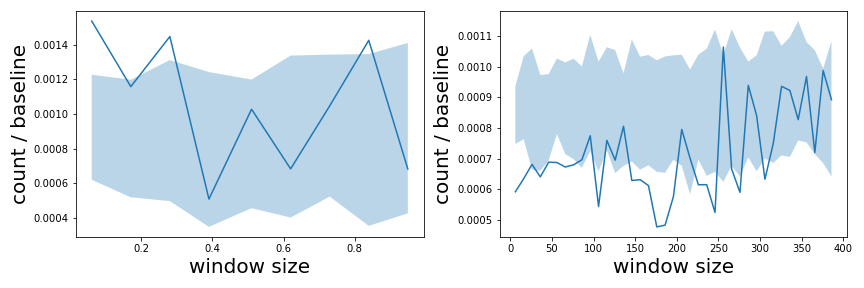

In [169]:
%matplotlib notebook
test_res_df_onoff = test_res_df.loc[1]
test_res_df_onoff=test_res_df_onoff.loc[test_res_df_onoff['window_size']>0]

test_res_df_onoff_small = test_res_df_onoff.loc[test_res_df_onoff['window_high']<=1]
test_res_df_onoff_big = test_res_df_onoff.loc[test_res_df_onoff['window_high']>1]
fig,axs=plt.subplots(1,2,figsize=(12,4))
fig,ax=cpp.plot_pairwise_coswitch_test_result_one(test_res_df_onoff_small,normalize_by_key='baseline',fig=fig,ax=axs[0],plot_kws={})
fig,ax=cpp.plot_pairwise_coswitch_test_result_one(test_res_df_onoff_big,normalize_by_key='baseline',fig=fig,ax=axs[1],plot_kws={})
plt.tight_layout()


In [122]:
test_res['changes_df_combined']

0    1    2    3    4    5    6    7    8    9   ...   15   16  \
both 40  0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
     50  0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
     54  1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
     55  0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
     63  0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1    352 0  0.0  NaN  0.0  NaN  NaN  0.0  NaN  NaN  0.0  NaN  ...  0.0  NaN   
         1  0.0  NaN  0.0  NaN  NaN  0.0  NaN  NaN  0.0  NaN  ...  0.0  NaN   
     355 0  0.0  NaN  0.0  NaN  NaN  0.0  NaN  NaN  0.0  NaN  ...  0.0  NaN   
     361 2  0.0  NaN  0.0  NaN  NaN  0.0  NaN  NaN  0.0  NaN  ...  1.0  NaN   
     362 0  0.0  NaN  0.0  NaN  NaN  0.0  NaN  NaN  0.0  NaN  ...  0.0  NaN   

             17   18   19   20   21   22   23   24  
both 40  0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
     50  0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
     54  1  0.0  0.0  0.0 -1.0  0.0  0.0  0.0  0.0  
     55  0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
     63  0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...         ...  ...  ...  ...  ...  ...  ...  ...  
1    352 0  0.0  NaN  1.0  NaN  0.0  NaN  NaN  NaN  
         1  1.0  NaN  0.0  NaN  0.0  NaN  NaN  NaN  
     355 0  1.0  NaN  0.0  NaN  0.0  NaN  NaN  NaN  
     361 2 -1.0  NaN  0.0  NaN  0.0  NaN  NaN  NaN  
     362 0  0.0  NaN  0.0  NaN  1.0  NaN  NaN  NaN  

[588 rows x 25 columns]

<IPython.core.display.Javascript object>


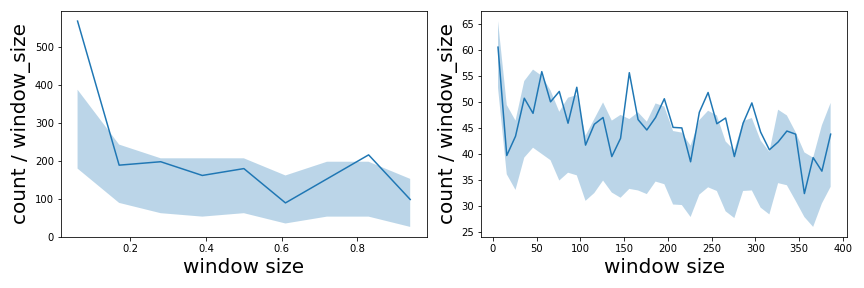

In [72]:
%matplotlib notebook
test_res_df_onoff = test_res_df.loc[1]
test_res_df_onoff=test_res_df_onoff.loc[test_res_df_onoff['window_size']>0]

test_res_df_onoff_small = test_res_df_onoff.loc[test_res_df_onoff['window_high']<=1]
test_res_df_onoff_big = test_res_df_onoff.loc[test_res_df_onoff['window_high']>1]
fig,axs=plt.subplots(1,2,figsize=(12,4))
fig,ax=cpp.plot_pairwise_coswitch_test_result_one(test_res_df_onoff_small,normalize_by_key='window_size',fig=fig,ax=axs[0],plot_kws={})
fig,ax=cpp.plot_pairwise_coswitch_test_result_one(test_res_df_onoff_big,normalize_by_key='window_size',fig=fig,ax=axs[1],plot_kws={})
plt.tight_layout()


<IPython.core.display.Javascript object>


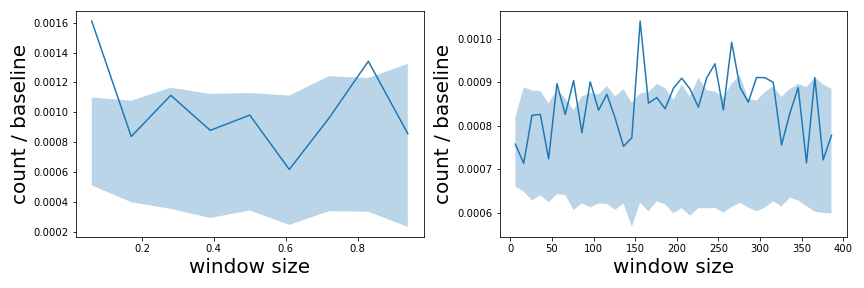

In [88]:
test_res.keys()

dict_keys(['test_res_df', 'count_shuffle', 'all_sw_times_v_combined', 'all_fields_times_v', 'changes_df_combined', 'changes_df_combined_d', 'pf_loc_combined', 'trial_pos_info', 'pos_to_time_func_per_trial', 'pf_all_field_combined'])

In [104]:
changes_df_combined_d = test_res['changes_df_combined_d']
pos_to_time_func_per_trial = test_res['pos_to_time_func_per_trial']
pf_loc_combined = test_res['pf_loc_combined']
all_sw_times_v_combined = test_res['all_sw_times_v_combined']

In [105]:
all_sw_times_v_combined

,trialtype,uid,field_index,time,v,field_pos,trial_index,switch
0,both,67,0,6649.543333,12.738086,11.0,1,1.0
1,both,113,1,6650.693633,33.918549,28.0,1,-1.0
2,both,170,0,6648.293033,0.055908,1.0,1,1.0
3,both,246,0,6648.293033,0.055908,1.0,1,1.0
4,both,270,0,6651.027067,32.849604,32.0,1,-1.0
...,...,...,...,...,...,...,...,...
0,both,127,0,8244.581300,0.152344,2.0,31,1.0
1,0,95,1,8262.102433,13.228568,56.0,31,-1.0
2,0,118,1,8266.453533,16.869261,90.0,31,1.0
3,0,226,1,8262.369167,22.651238,60.0,31,1.0


In [106]:
all_sw_times_v_combined_shuffle_l = cpacas.shuffle_changes_df_combined_get_sw_times_v_combined_shuffle(changes_df_combined_d,index_within_to_trial_index_df,pos_to_time_func_per_trial,pf_loc_combined,nrepeats=100,task_ind=0)
test_res_df_,c_shuffle_l_ =cpacas.sweep_test_coswitch(all_sw_times_v_combined,all_sw_times_v_combined_shuffle_l,[0,10],all_fields_times_v=None,onoff=1,p_thresh=0.05,ci=0.95,do_ratio=False,exclude_self=False,normalize_by_window=False)






In [116]:
test_res_df_,c_shuffle_l_ =cpacas.sweep_test_coswitch(all_sw_times_v_combined,all_sw_times_v_combined_shuffle_l,[1,10],all_fields_times_v=None,onoff=1,p_thresh=0.05,ci=0.95,do_ratio=False,exclude_self=False,normalize_by_window=False)




In [117]:
test_res_df_

,window_low,window_high,count,pval,sig,count_ci_low,count_ci_up,window_size,window_median
0,1,10,561,0.19,False,481.95,589.25,9,5.5


In [ ]:
fig,axs = cpp.plot_pairwise_coswitch_test_result_both(test_res_df,normalize_by_key='window_size',fig=None,ax=None,plot_kws={})




/mnt/home/szheng/projects/nmf_analysis/change_point_plot.py:166: RuntimeWarning: invalid value encountered in long_scalars
  ys = ys / test_res_df_onoff[normalize_by_key].values


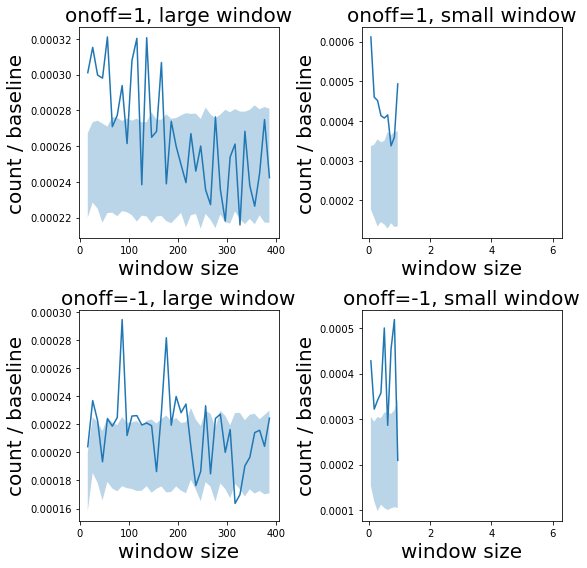

In [55]:
%matplotlib inline
fig,axs = cpp.plot_pairwise_coswitch_test_result_both(test_res_df,normalize_by_key='baseline',fig=None,ax=None,plot_kws={})




In [39]:
test_res['all_sw_times_v_combined']

,trialtype,uid,field_index,time,v,field_pos,trial_index,switch
0,both,67,0,6649.543333,12.738086,11.0,1,1.0
1,both,113,1,6650.693633,33.918549,28.0,1,-1.0
2,both,170,0,6648.293033,0.055908,1.0,1,1.0
3,both,246,0,6648.293033,0.055908,1.0,1,1.0
4,both,270,0,6651.027067,32.849604,32.0,1,-1.0
...,...,...,...,...,...,...,...,...
0,both,127,0,8244.581300,0.152344,2.0,31,1.0
1,0,95,1,8262.102433,13.228568,56.0,31,-1.0
2,0,118,1,8266.453533,16.869261,90.0,31,1.0
3,0,226,1,8262.369167,22.651238,60.0,31,1.0


/mnt/home/szheng/projects/nmf_analysis/change_point_plot.py:166: RuntimeWarning: invalid value encountered in long_scalars
  ys = ys / test_res_df_onoff[normalize_by_key].values


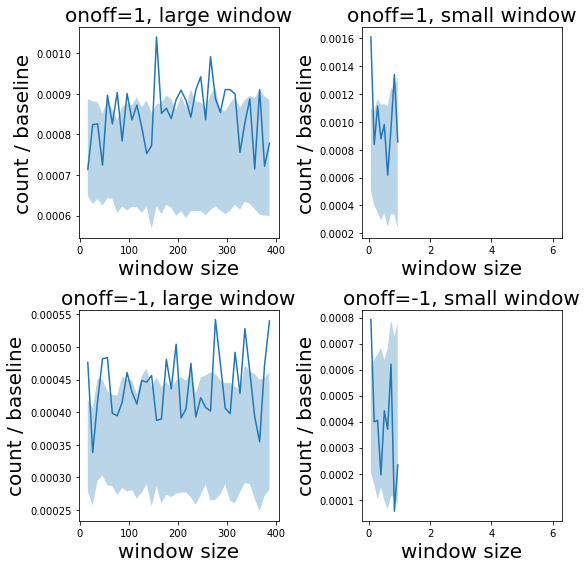

In [20]:
%matplotlib inline
fig,axs = cpp.plot_pairwise_coswitch_test_result_both(test_res_df,normalize_by_key='baseline',fig=None,ax=None,plot_kws={})


